In [1]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randint, randn

In [2]:
from keras.datasets.cifar10 import load_data
from keras.layers import Dense,Conv2D,Conv2DTranspose,AveragePooling2D,Dropout,Flatten,BatchNormalization,Reshape,LeakyReLU
from keras.optimizers import Adam
from keras.models import Sequential

2023-08-06 03:44:55.128473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 03:44:55.304844: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-06 03:44:55.872570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-06 03:44:55.872680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
import glob
import random
import os

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Get list of image names

In [5]:
fl_names = glob.glob('Bollywood_celeb_face_localized/*/*/*.jpg')

## Shuffle image names (optional)

In [6]:
random.shuffle(fl_names)

In [7]:
trainX= [] 
for i in fl_names:
    try:
        img = cv2.imread(i)
        cnvt_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        trainX.append(cnvt_color)
    except:
        print(i)
        continue

## Plot images

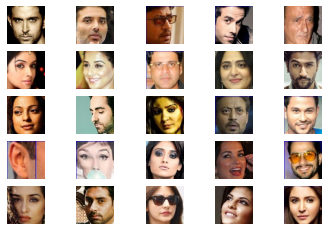

In [8]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(trainX[i])

## Discriminator

In [9]:
def define_discriminator(in_shape=(64,64,3)): 
    model = Sequential()
    #64,64,3
    model.add(Conv2D(128, (3,3), strides=(2,2), padding ='same', input_shape = in_shape))
    model.add(LeakyReLU(alpha=0.2))
    #32,32,3
    
    model.add(Conv2D(128, (3,3), strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2)) 
    #16,16,3
    
    model.add(Conv2D(128, (3,3), strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2)) 
    #8,8,3
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation = 'sigmoid'))
    
    #compile
    opt= Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss ='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [10]:
test_discr =define_discriminator()
test_discr.summary()

2023-08-06 03:45:07.550795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 03:45:07.588331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 03:45:07.589799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 03:45:07.592151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

 SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 03:45:08.277146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8884 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:02.0, compute capability: 7.5
/home/spandey/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Generator

In [11]:
def define_generator(latent_dim):
    model = Sequential()
    
    n_nodes = 128*8*8
    model.add(Dense(n_nodes,input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,128)))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # 16,16,128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # 32,32,128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # 64,64,128
    
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
    
    return model

In [12]:
test_gen = define_generator(200)
test_gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1646592   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

## GAN

In [13]:
def define_gan(generator, discriminator):
    discriminator.trainable = False # discriminator is trained separately
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [14]:
define_gan(test_gen,test_discr).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 3)         2457987   
                                                                 
 sequential (Sequential)     (None, 1)                 306945    
                                                                 
Total params: 2,764,932
Trainable params: 2,457,987
Non-trainable params: 306,945
_________________________________________________________________


## Utility functions

In [15]:
def load_real_samples(trainX):
    X = np.array(trainX).astype('float32')
    X = (X-127.5)/127.5
    return X

In [16]:
def generate_real_samples(dataset, n_samples):
    ix= randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples,1))
    return X,y

In [17]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [18]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = zeros((n_samples,1))
    return X,y

## Train function

In [19]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=256):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    
    for i in range(n_epochs):  
        for j in range(bat_per_epo):
            
            #train discriminator on real(size half batch) and fake(size half batch) 
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # train mixed gan model here
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch,1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # print('Epoch>%d, Batch %d%d, d1=%.3f, d2=%.3f, d2=%.3f' % (i+1, j+1, bat_per_epo, d_loss_real,d_loss_fake, g_loss))
    g_model.save('bollywood_generator.h5')

## Initialize argumets

In [20]:
latent_dim = 200
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator,discriminator)

In [21]:
dataset = load_real_samples(trainX)

In [22]:
len(dataset)

8664

## Start training

In [ ]:
train( generator, discriminator, gan_model, dataset, latent_dim, n_epochs=500)

2023-08-06 03:45:29.564333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-08-06 03:45:29.988320: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/4 [==============================] - 0s 13ms/step


# Test

In [ ]:
from keras.models import load_model
from numpy.random import  randn

In [ ]:
def show_plot(examples, n):
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis('off')
        plt.imshow(examples[i])
        plt.show()

In [ ]:
model = load_model('bollywood_generator.h5')

In [ ]:
latent_points = generate_latent_points(200,25)

In [ ]:
X = model.predict(latent_points)

In [ ]:
X = (X*255).astype(np.uint8)

## Save generated output

In [ ]:
for k,i in enumerate(X):
    Image.fromarray(i).save('gan_out/'+str(k)+'.jpeg')

## Plot generated output

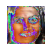

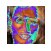

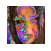

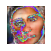

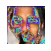

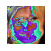

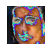

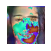

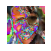

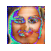

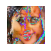

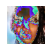

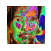

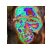

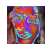

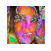

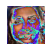

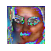

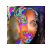

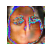

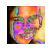

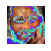

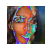

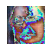

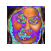

In [32]:
show_plot(X,5)